# Developing market models using frequentist linear regression

In [24]:
# Install Yahoo finance package
# Import relevant Python packages
import statsmodels.api as sm
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from datetime import datetime

# Import financial data
start = datetime(1993, 3, 1)
end = datetime(2023, 3, 1)

In [25]:


# S&P 500 index is a proxy for the market
market = yf.Ticker('SPY').history(start=start, end=end)
# Ticker symbol for Apple, the most liquid stock in the world
stock = yf.Ticker('AAPL').history(start=start, end=end)
# 10 year US treasury note is the proxy for risk free rate
riskfree_rate = yf.Ticker('^TNX').history(start=start, end=end)
# Create dataframe to hold daily returns of securities



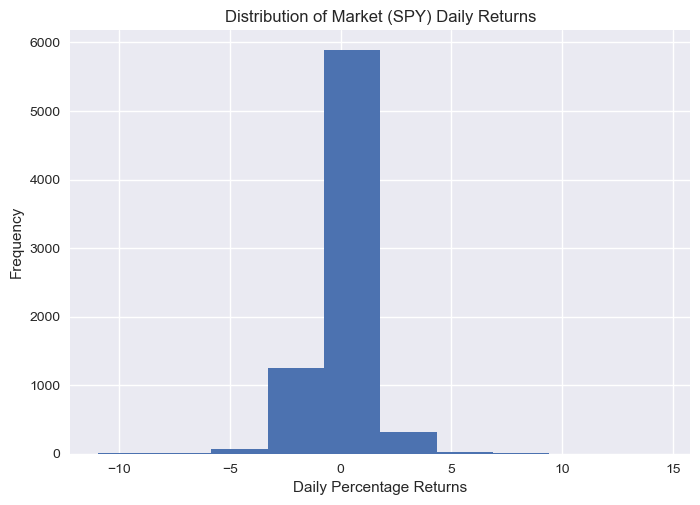

Descriptive Statistics of the Market's daily percentage returns:
count    7554.000000
mean        0.043484
std         1.192538
min       -10.942392
25%        -0.448813
50%         0.066898
75%         0.595501
max        14.519795
Name: market, dtype: float64


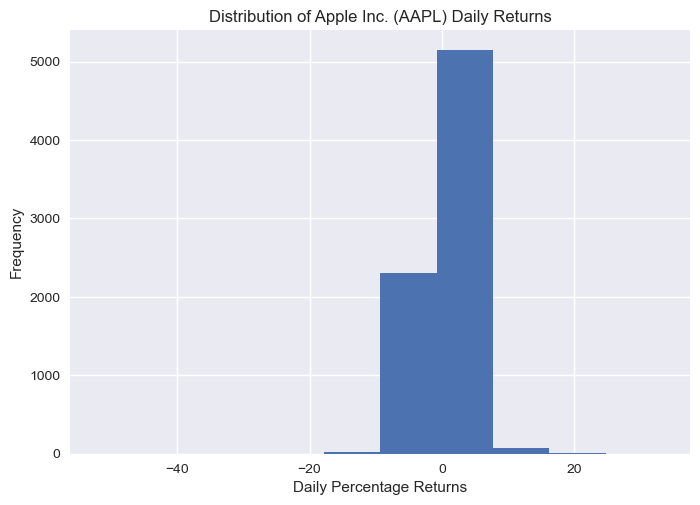

Descriptive Statistics of the Apple's daily percentage returns:
count    7554.000000
mean        0.116955
std         2.741895
min       -51.869190
25%        -1.185797
50%         0.050984
75%         1.391307
max        33.228040
Name: stock, dtype: float64
Nombre de valeurs NaN dans riskfree: 21
DatetimeIndex(['1993-10-11', '1993-11-11', '1994-01-17', '1994-10-10',
               '1995-10-09', '1996-01-15', '1996-10-14', '1996-11-11',
               '1997-01-20', '1997-10-13', '1997-11-11', '1998-10-12',
               '1998-11-11', '1999-10-11', '1999-11-11', '2003-11-11',
               '2005-10-10', '2005-11-11', '2006-10-09', '2010-10-11',
               '2016-11-11'],
              dtype='datetime64[ns]', name='Date', freq=None)
Descriptive Statistics of the 10 year note daily percentage returns:
count    7534.000000
mean        0.004217
std         0.001073
min         0.001125
25%         0.003378
50%         0.004390
75%         0.005092
max         0.006129
Name: riskfree, 

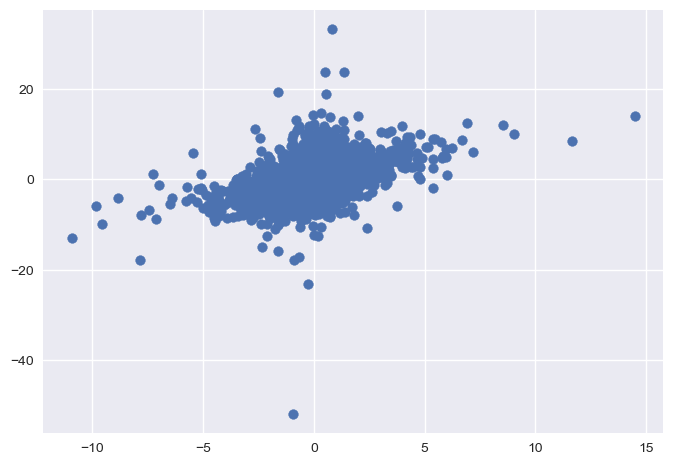

In [32]:



daily_returns = pd.DataFrame()
daily_returns['market'] = market['Close'].pct_change(1)*100
daily_returns['stock'] = stock['Close'].pct_change(1)*100
# Compounded daily rate based on 360 days for the calendar year used in the bond market


test = (1 + riskfree_rate['Close']) ** (1 / 360) - 1
test = test.tz_localize(None)
daily_returns = daily_returns.tz_localize(None)

daily_returns['riskfree'] = test
# Plot and summarize the distribution of daily returns
plt.hist(daily_returns['market']), plt.title('Distribution of Market (SPY) Daily Returns'), plt.xlabel('Daily Percentage Returns'), plt.ylabel('Frequency'), plt.show()
# Analyze descriptive statistics
print("Descriptive Statistics of the Market's daily percentage returns:\n{}".format(daily_returns['market'].describe()))

plt.hist(daily_returns['stock']), plt.title('Distribution of Apple Inc. (AAPL) Daily Returns'), plt.xlabel('Daily Percentage Returns'), plt.ylabel('Frequency'), plt.show()
# Analyze descriptive statistics
print("Descriptive Statistics of the Apple's daily percentage returns:\n{}".format(daily_returns['stock'].describe()))






# Vérifier combien de valeurs NaN sont présentes
print(f"Nombre de valeurs NaN dans riskfree: {daily_returns['riskfree'].isna().sum()}")

# Examiner où les NaN apparaissent (si vous avez un index temporel)
if daily_returns.index.dtype.kind == 'M':  # Si l'index est de type datetime
    print(daily_returns[daily_returns['riskfree'].isna()].index)





# Analyze descriptive statistics
print("Descriptive Statistics of the 10 year note daily percentage returns:\n{}".format(daily_returns['riskfree'].describe()))
# Examine missing rows in the dataframe
market.index.difference(riskfree_rate.index)
# Fill rows with previous day's risk-free rate since daily rates are generally stable
daily_returns = daily_returns.ffill()
# Drop NaNs in first row because of percentage calculations
daily_returns = daily_returns.dropna()
# Check dataframe for null values
daily_returns.isnull().sum()
# Check first five rows of dataframe
daily_returns.head()
# AAPL's Market Model based on daily excess returns

# Daily excess returns of AAPL
y = daily_returns['stock'] - daily_returns['riskfree']
# Daily excess returns of the market
x = daily_returns['market'] - daily_returns['riskfree']

# Plot the data
plt.scatter(x,y)



# Add the constant vector to obtain the intecept
x = sm.add_constant(x)

# Use Ordinary Least Squares algorithm to find the line of best fit
# Créer le modèle
market_model = sm.OLS(y, x)

# Ajuster le modèle aux données
market_model_fit = market_model.fit()

# Accéder aux paramètres du modèle ajusté
print("According to AAPL's Market Model, the security had a realized Alpha of {0}% and Beta of {1}".format(
    round(market_model_fit.params['const'], 2),
    round(market_model_fit.params[0], 2)
))



In [34]:
print(market_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     2276.
Date:                Fri, 09 May 2025   Prob (F-statistic):               0.00
Time:                        14:13:58   Log-Likelihood:                -17342.
No. Observations:                7554   AIC:                         3.469e+04
Df Residuals:                    7552   BIC:                         3.470e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0693      0.028      2.504      0.0